In [1]:
import re
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('..')
from seismicpro import Survey, SeismicDataset, SU, SeismicIndex

from seismicpro.batchflow import DatasetIndex, W, B, V
from seismicpro.batchflow.models.torch import UNet, ResBlock
from seismicpro.batchflow.batchflow.named_expr import eval_expr

%env CUDA_VISIBLE_DEVICES=1, 5

env: CUDA_VISIBLE_DEVICES=1, 5


In [2]:
%%time
path = './Carich_Kuvaik_line_shot_Pick2.sgy'
picking_path = 'Car_MANUAL_pick_off-3000_50shots'
sur = Survey(path=path, header_index='FieldRecord', header_cols=['FieldRecord', 'TraceNumber'], name='raw')
sur.load_picking(picking_path)

CPU times: user 4.19 s, sys: 3.39 s, total: 7.58 s
Wall time: 7.57 s


In [3]:
ix = SeismicIndex(surveys=sur)
ix.split(shuffle=42)

train_ix = ix.train.reindex('TRACE_SEQUENCE_FILE')
dataset_train = SeismicDataset(train_ix)
dataset_test = SeismicDataset(ix.test)

In [4]:
config = {
    'inputs': {'masks': dict(classes=2)},
    'body/encoder/blocks': dict(base=ResBlock, kernel_size=5, filters=[8, 16, 32, 64], attention='scse'),
    'body/decoder/blocks': dict(base=ResBlock, kernel_size=5, filters=[8, 16, 32, 64][::-1], attention='scse'),        
    'body/embedding': dict(filters=128, kernel_size=5),
    'optimizer': ('Adam', {'lr': 0.001}),
    'common/conv/kernel_size': 5,
}

In [5]:
ppl = (dataset_train.p
      .init_variable('loss', [])
      .load(src='raw', fmt='segy', combined=True)
      .scale_standard(src='raw', dst='raw')
      .pick_to_mask(src='raw', dst='raw')
      .init_model('dynamic', UNet, 'my_model', config=config)
      .train_model('my_model', 
                   images=SU('raw').data.transpose((1, 0, 2)),
                   targets=SU('raw').mask.squeeze(),
                   fetches='loss', save_to=V('loss', mode='a'))
      .run_later(1500, n_epochs=5, drop_last=True, shuffle=42, bar='n')
)

In [6]:
%%time
ppl.run()

  0%|                                                                                                         …

../seismicpro/batchflow/batchflow/models/torch/unet.py:104: UserWarning: 'decoder/upsample/filters' are not set and can be inconsistent with 'decoder/blocks/filters'! Please revise your model's config. In future, upsample filters can be made to match decoder block's filters by default.
  "In future, upsample filters can be made to match decoder block's filters by default.")


CPU times: user 2min 26s, sys: 54.5 s, total: 3min 20s
Wall time: 3min 21s


In [8]:
ppl.show_profile_info(per_iter=False, detailed=False)

total_time                     pipeline_time            \
                        sum      mean       max           sum      mean   
action                                                                    
train_model #3    49.871314  0.289949  4.606725     49.010295  0.284944   
load #0            4.879051  0.028367  0.130523      3.580852  0.020819   
pick_to_mask #2    1.175209  0.006833  0.010967      0.682302  0.003967   
normalize_std #1   1.055987  0.006139  0.012745      0.634125  0.003687   

                            
                       max  
action                      
train_model #3    4.595895  
load #0           0.123164  
pick_to_mask #2   0.007439  
normalize_std #1  0.009461

In [7]:
ppl.save_model_now('my_model', path='trained_model_new.dill')

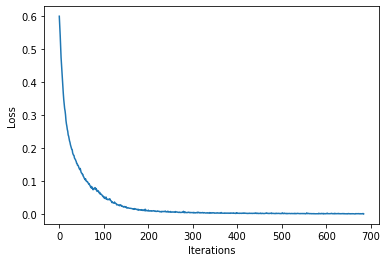

In [8]:
import matplotlib.pyplot as plt
loss = ppl.v('loss')
plt.xlabel("Iterations"), plt.ylabel("Loss")
plt.plot(loss)

In [9]:
config_predict = {
    'build': False,
    'load/path':  'trained_model_new.dill',
    'device': 'gpu:1'
}

test_pipeline = (dataset_test.p
    .add_namespace(np)
    .init_model('dynamic', UNet, 'my_model', config=config_predict) 
    .init_variable('true', [])
    .init_variable('traces', [])
    .init_variable('predictions', [])
    .load(src='raw', fmt='segy', limits=700)
    .sort(src='raw', by='offset')
    .scale_standard(src='raw', dst='raw')
    .update(V('traces', mode='e'), SU('raw').data)
    .update(V('true', mode='e'), SU('raw')['Picking'])
    .make_data(src=SU('raw').data, dst='inputs', concat_axis=0, expand_dims_axis=1)
    .predict_model('my_model', B('inputs'),
                 fetches='predictions', save_to=B('preds'))
    .call(lambda batch: np.argmax(batch.preds, axis=1), save_to=B('preds'))
    .split_results(src='preds', dst=SU('raw', wrap=True).mask, shapes=SU('raw').shape[:, 0])
    .mask_to_pick(src='raw', dst='raw', col_name='Predict')
    .update(V('predictions', mode='e'), SU('raw')['Predict'])
)

In [10]:
test_pipeline.run(1, n_epochs=1, drop_last=False, shuffle=False, bar='n')

  0%|                                                                                                         …

In [11]:
true = np.array(test_pipeline.v('true')) 
pred = np.array(test_pipeline.v('predictions'))
traces = np.array(test_pipeline.v('traces'))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

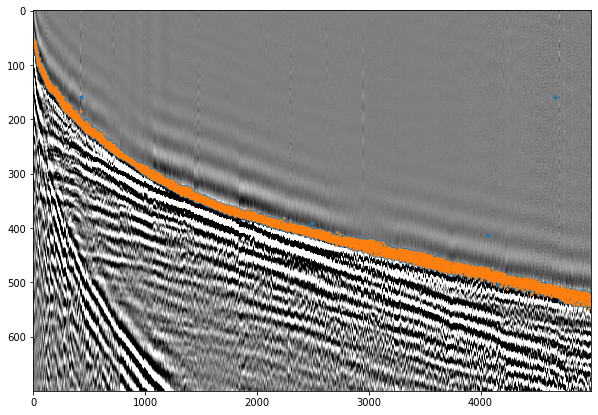

In [12]:
i = 0
plt.figure(figsize=(10, 7))
plt.imshow(traces[i].T, aspect='auto', cmap='gray', vmin=-0.5, vmax=0.5)
plt.scatter(np.arange(len(pred[i])), (pred[i]/2), 10);
plt.scatter(np.arange(len(true[i])), (true[i]/2), 3);

In [13]:
print('MAE, milliseconds: {0:.3f}'.format(np.mean(np.abs(np.concatenate(true)-np.concatenate(pred)))))

MAE, milliseconds: 1.250
